# ◀◀◀◀◀ SUDOKU puzzle digit **Recognisizer🔍** and **Solver🔢** ▶▶▶▶▶


---



# 📓 In this Notebook, as per the  task, I have trained the MLP model **using  given lable** data that will **recognise the digits** then, train a CNN model that will **solve** the sudoku puzzle.

# ☝ **First approch towards the solution.**

**Steps in TASK 1:**

1. Studied Sudoku images (252x252) with 41 filled digits.
2. Extracted 28x28 pixel numbers from each puzzle position using window size of 28x28 with stride 28. Hence, **created new dataset** of 28x28 subarrays.
3. Organized input data with these smaller images in new array.
4. Added missing IDs to label data, setting them as 0.
5. Converted label numbers to simple int32 format.
6. Combined input data with labels for training.
7. Chose PyTorch to train a simple model multilayer perceptron (MLP).
8. Trained the model to solve Sudoku puzzles.

**Steps in TASK 2:**

1. Imported libraries: torch, numpy, csv, time, torch.nn, matplotlib.pyplot, Google Colab utilities.
2. Loaded 50,000 training pairs of partially and completely filled Sudoku images.
3. Created chunks of training data and labels, and loaded test Sudoku images.
4. Defined and loaded a pre-trained neural network model for Sudoku solving.
5. Extracted unsolved train, solved train and unsolved test Sudoku grids from training images, labeled training images and test images respectively using predefined windows.
6. Processed and updated the grids with predicted digits based on confidence threshold.
7. Saved and downloaded the extracted unsolved Sudoku grids from training images.
8. Visualized side-by-side comparisons of unsolved and solved Sudoku images.
9. Saved and downloaded the extracted unsolved Sudoku grids from test images.
10. Loaded unsolved and solved Sudoku datasets, removed pairs with labels containing zeros.
11. Converted data to PyTorch tensors, split into training and validation sets.
12. Trained a convolutional neural network model for Sudoku solving over multiple epochs.

## ✅ **TASK 1**


1. TASK Origin: This Sudoku-solving TASK is MAI program's Artificial Neural Networks and Cognitive Models course.

2. Two Tasks: The project is divided into two tasks. Task 1 involves training a model to interpret a Sudoku puzzle and identify digits and their positions. Task 2 focuses on training a model to solve the Sudoku puzzle by completing empty cells using standard rules.

3. Puzzle Description: The Sudoku puzzle is a 9x9 grid with digits from 1 to 9, following Sudoku rules. Each column, row, and 3x3 subgrid must contain all digits. The provided incomplete grid has 40 empty cells.

4. Model Objective (Task 1): The goal is to train a model that recognizes filled digits within the puzzle and their corresponding positions in the grid. The model should provide a list of cells containing digits.

5. Training Data: A dataset of 50,000 training images of partially solved Sudoku puzzles is provided, along with labels indicating coordinates of 41 filled positions in each image.

6. Test Set: The model's performance is evaluated on a test set comprising 10,000 images, and its ability to recognize digits and positions is assessed.

### 🔹 **Preprocessing of given datasets.**

In [ ]:
# @title Imported necessary libraries.
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive to access files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Defined file paths for the datasets

images_path = '/content/drive/MyDrive/Sudoko Dataset Task 1/train/imgs.npy'
labels_path = '/content/drive/MyDrive/Sudoko Dataset Task 1/train/known_values_labels.npy'

# Load Sudoku image data and labels using NumPy
images_np = np.load(images_path)
all_label = np.load(labels_path)

In [ ]:
# @title Chunk of image and labels
number = 4000
chunk_of_image = images_np[:number]
labels = all_label[:number]

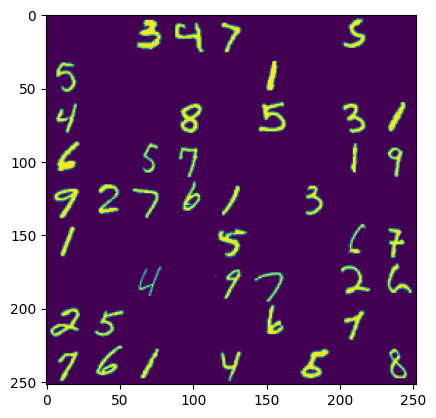

In [ ]:
# @title Viewed data image
plt.imshow(chunk_of_image[0])

In [ ]:
# @title Function to extract 28x28 matrices from larger matrices
def extract_28x28_matrices(matrix, window_size, stride):
    rows, cols = matrix.shape
    extracted_matrices = []

    for i in range(0, rows - window_size + 1, stride):
        for j in range(0, cols - window_size + 1, stride):
            extracted_matrices.append(matrix[i:i+window_size, j:j+window_size])

    return extracted_matrices

In [ ]:
# @title Create dataset of 28x28 matrices
window_size = 28
stride_value = 28
all_extracted_matrices = []

for matrix in chunk_of_image:
    extracted_matrices = extract_28x28_matrices(matrix, window_size, stride_value)
    all_extracted_matrices.extend(extracted_matrices)

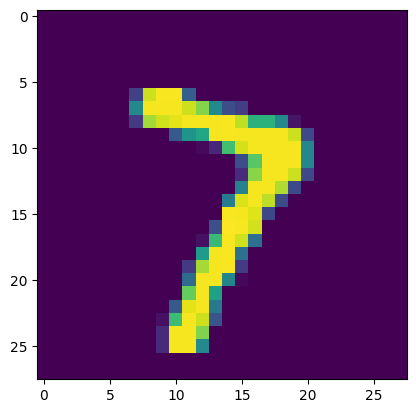

In [ ]:
# @title Viewed extracted image to verify
plt.imshow(all_extracted_matrices[4])

In [ ]:
# @title Convert the list of matrices into a single NumPy array
all_matrices_array = np.array(all_extracted_matrices)

In [ ]:
# @title Added missing IDs and append them to the dataset and  added 0 as lable  for  missing 0.
def append_missing_ids(data):
    new_data = []
    for i in range(9):
        row = []
        for j in range(9):
            found = False
            for d in data:
                if d[0] == i and d[1] == j:
                    row.append(list(d))
                    found = True
                    break
            if not found:
                row.append([float(i), float(j), 0])  # Add missing IDs
        new_data.append(row)
    return np.array(new_data)

# Process the dataset and extract labels
dataset = labels
new_dataset = []
for data in dataset:
    new_data = append_missing_ids(data)
    new_dataset.append(new_data)

new_dataset = np.array(new_dataset).reshape(len(labels) * 81, 3)

(array([[0., 0., 0.],
        [0., 1., 0.],
        [0., 2., 3.],
        ...,
        [8., 6., 0.],
        [8., 7., 0.],
        [8., 8., 0.]]),
 <matplotlib.image.AxesImage at 0x7c07b688b3d0>)

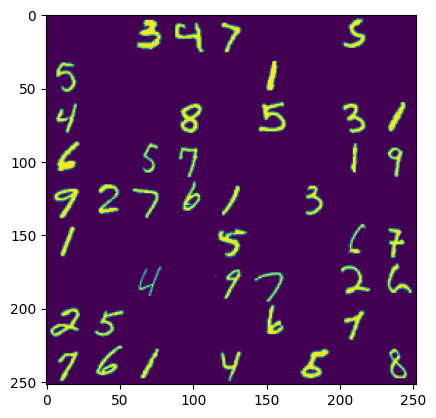

In [ ]:
# @title Side by side view to  check if image has extracted correctly or not.
new_dataset,plt.imshow(chunk_of_image[0])

In [ ]:
# @title Converted each lable into integer and then converted into numpy array.
test = np.array([int(i[2]) for i in new_dataset])
test

array([0, 0, 3, ..., 0, 0, 0])

### 🔹 **Trained model using given label data using PYTORCH**

In [ ]:
# @title USING PYTORCH DIGIT RECOGNITION MODEL
# Convert data to PyTorch tensors
images_data = all_matrices_array
labels_data = test
images_tensor = torch.tensor(images_data).float()
labels_tensor = torch.tensor(labels_data).long()

# Split the data into train and test sets
split_ratio = 0.8
split_idx = int(len(images_tensor) * split_ratio)
train_images, test_images = images_tensor[:split_idx], images_tensor[split_idx:]
train_labels, test_labels = labels_tensor[:split_idx], labels_tensor[split_idx:]

# Define a simple neural network architecture
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

# Initialize the model, criterion, optimizer, and other settings
model = SimpleNN()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
batch_size = 64
epochs = 5

# Create DataLoader for train and test sets
train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Lists to store metrics for plotting
train_losses = []
test_losses = []
accuracies = []

# Training the model
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    correct = 0
    total = 0
    confusion_mat = torch.zeros(10, 10)

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update confusion matrix
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_mat[t.long(), p.long()] += 1

    test_loss = nn.NLLLoss()(outputs, labels).item()
    test_losses.append(test_loss)

    accuracy = correct / total * 100
    accuracies.append(accuracy)
    print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

Epoch [1/5], Train Loss: 0.1344, Test Loss: 0.0372, Accuracy: 98.35%
Epoch [2/5], Train Loss: 0.0530, Test Loss: 0.0139, Accuracy: 98.63%
Epoch [3/5], Train Loss: 0.0424, Test Loss: 0.0008, Accuracy: 98.87%
Epoch [4/5], Train Loss: 0.0355, Test Loss: 0.0423, Accuracy: 99.12%
Epoch [5/5], Train Loss: 0.0314, Test Loss: 0.0024, Accuracy: 99.10%


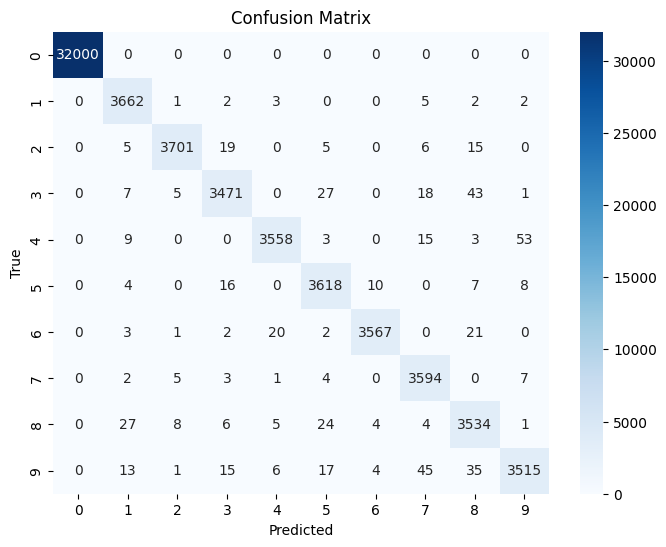

Epoch [5/5], Train Loss: 0.0314, Test Loss: 0.0024, Accuracy: 99.10%


In [ ]:
# @title Plotted Confusion Matrix
# Visualize confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_mat.int().numpy(), annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

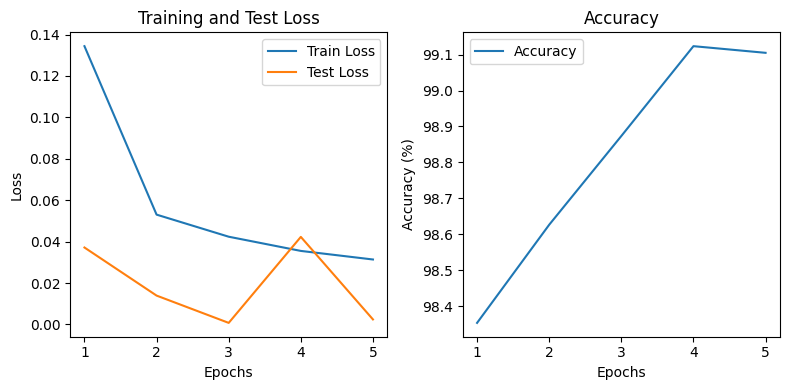

In [ ]:
# @title Plotted Loss and accuracy over the Epochs

# Plotting
plt.figure(figsize=(8, 4))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), accuracies, label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# @title Saved the trained model
torch.save(model.state_dict(), 'sudoku_cnn_model.pth')

### 🔹 **Digit Recognition of TEST data**

In [ ]:
# @title Load Sudoku image data and labels using NumPy
testimages = np.load('/content/drive/MyDrive/Sudoko Dataset Task 1/test/imgs.npy')

In [ ]:
# @title Chunk of test image dataset
test_images = testimages[:]

In [ ]:
# @title  Digit Recognition of TEST data
import torch
import numpy as np
import csv
import time
import torch.nn as nn

start_time = time.time()
# Define a simple neural network architecture
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

# Load the pre-trained weights for SimpleNN model
pretrained_model = SimpleNN()
pretrained_model.load_state_dict(torch.load('/content/sudoku_cnn_model.pth'))
pretrained_model.eval()

# Parameters for processing Sudoku images
window_size = 28
step_size = 28
confidence_threshold = 0.7
resulting_arrays = []

# Function to update Sudoku grid
def update_sudoku_grid(grid, row, col, digit):
    # Update the grid with a predicted digit at specified row and column
    if row < 9 and col < 9:
        grid[row][col] = digit

# Load Sudoku image data
data = test_images

# Process each Sudoku image
for idx, sudoku_image in enumerate(data):
    print(f"Processing Image {idx + 1}/{len(data)}")
    sudoku_grid = np.zeros((9, 9), dtype=np.uint8)

    # Extract windows and predict digits within the Sudoku image
    for y in range(0, sudoku_image.shape[0] - window_size + 1, step_size):
        for x in range(0, sudoku_image.shape[1] - window_size + 1, step_size):
            window = sudoku_image[y:y + window_size, x:x + window_size]
            window = window.reshape(-1, 28 * 28)
            window = window.astype('float32') #/ 255.0

            # Convert the window data to tensors for model input
            window_tensor = torch.from_numpy(window)
            window_tensor = window_tensor.view(-1, 1, 28, 28)

            # Make predictions using the pre-trained model
            with torch.no_grad():
                predictions = pretrained_model(window_tensor)
                predicted_digit = torch.argmax(predictions, dim=1)
                confidence = torch.max(torch.softmax(predictions, dim=1))

            grid_row = y // (sudoku_image.shape[0] // 9)
            grid_col = x // (sudoku_image.shape[1] // 9)
            update_sudoku_grid(sudoku_grid, grid_row, grid_col, predicted_digit.item())


            # # Apply confidence threshold to predicted digits
            # if confidence > confidence_threshold:
            #     # Calculate the position in the Sudoku grid and update the grid
            #     grid_row = y // (sudoku_image.shape[0] // 9)
            #     grid_col = x // (sudoku_image.shape[1] // 9)
            #     update_sudoku_grid(sudoku_grid, grid_row, grid_col, predicted_digit.item())

    resulting_arrays.append(sudoku_grid)

Streaming output truncated to the last 5000 lines.
Processing Image 5001/10000
Processing Image 5002/10000
Processing Image 5003/10000
Processing Image 5004/10000
Processing Image 5005/10000
Processing Image 5006/10000
Processing Image 5007/10000
Processing Image 5008/10000
Processing Image 5009/10000
Processing Image 5010/10000
Processing Image 5011/10000
Processing Image 5012/10000
Processing Image 5013/10000
Processing Image 5014/10000
Processing Image 5015/10000
Processing Image 5016/10000
Processing Image 5017/10000
Processing Image 5018/10000
Processing Image 5019/10000
Processing Image 5020/10000
Processing Image 5021/10000
Processing Image 5022/10000
Processing Image 5023/10000
Processing Image 5024/10000
Processing Image 5025/10000
Processing Image 5026/10000
Processing Image 5027/10000
Processing Image 5028/10000
Processing Image 5029/10000
Processing Image 5030/10000
Processing Image 5031/10000
Processing Image 5032/10000
Processing Image 5033/10000
Processing Image 5034/100

### 🔹 **Created Sumbission file.**

In [ ]:
# @title Prepared content for submission in CSV format
submission_content = [['id', 'value']]
for image_id, grid in enumerate(resulting_arrays):
    for row_idx, row in enumerate(grid):
        for col_idx, cell_value in enumerate(row):
            cell_id = f"{image_id}_{row_idx}{col_idx:01}"
            submission_content.append([cell_id, cell_value])

# Write submission content to a CSV file
submission_filename = 'submission.csv'
with open(submission_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(submission_content)

print(f"Submission file '{submission_filename}' has been created.")

# Calculate and display the processing time
end_time = time.time()
time_difference_seconds = end_time - start_time
time_difference_minutes = time_difference_seconds / 60
print("Time taken: {:.2f} minutes".format(time_difference_minutes))

Submission file 'submission.csv' has been created.
Time taken: 2.54 minutes


In [ ]:
# @title Predicted digits and their position
pd.read_csv('/content/submission.csv')

,id,value
0,0_00,2
1,0_01,0
2,0_02,7
3,0_03,0
4,0_04,1
...,...,...
809995,9999_84,3
809996,9999_85,5
809997,9999_86,2
809998,9999_87,0


(array([[2, 0, 7, 0, 1, 3, 4, 0, 0],
        [8, 0, 6, 0, 4, 9, 2, 3, 5],
        [9, 0, 3, 0, 0, 6, 8, 0, 0],
        [0, 9, 0, 0, 5, 0, 0, 2, 0],
        [1, 0, 8, 9, 7, 0, 5, 6, 0],
        [0, 3, 0, 0, 0, 2, 0, 0, 8],
        [3, 6, 1, 4, 0, 0, 7, 8, 0],
        [0, 8, 0, 0, 0, 7, 0, 1, 0],
        [4, 0, 2, 0, 8, 0, 3, 0, 0]], dtype=uint8),
 <matplotlib.image.AxesImage at 0x7c07994e1450>)

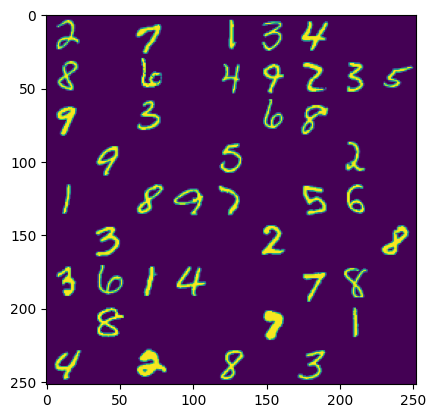

In [ ]:
# @title Compared the Predicted Grid.
resulting_arrays[0], plt.imshow(testimages[0])

## ✅ **TASK 2**

1. Description: This task involves training a model to complete Sudoku puzzles from partially filled images, building on Task 1's Sudoku image description.

2. Training Data: A set of 50,000 pairs of partially and completely filled Sudoku images is provided for model training.

3. Task: We have to train a model to complete 10,000 test Sudoku images that are partially filled. The model's performance is evaluated based on its ability to accurately fill in the missing cells in these test images.

### 🔹 **Loaded the Data of shape** (50000,252,252).

In [ ]:
# @title Imported important libraries
from google.colab import drive
import torch
import numpy as np
import csv
import time
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
# @title Mounted Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title Loaded Sudoku image data
path = '/content/drive/MyDrive/Sudoko Dataset Task 2/Train/imgs.npy'
data1 = np.load(path)

In [ ]:
# @title Created some chunk of dataset for training
chunk1 = data1[:]

In [ ]:
# @title Loaded Sudoku label data
path2 = '/content/drive/MyDrive/Sudoko Dataset Task 2/Train/labels.npy'
data2 = np.load(path2)

In [ ]:
# @title Created some chunk of dataset for training
chunk2 = data2[:]

In [ ]:
# @title Load Sudoku label test data
path3 = '/content/drive/MyDrive/Sudoko Dataset Task 2/Test/imgs.npy'
data3 = np.load(path3)

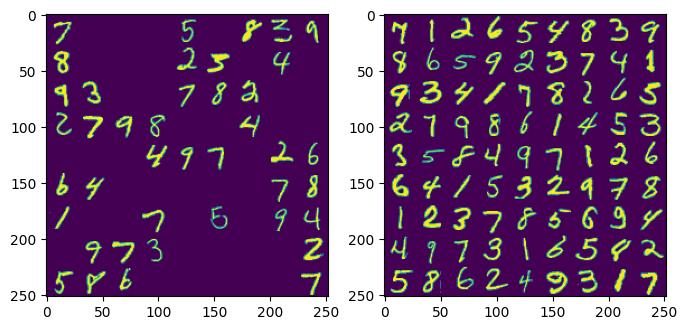

In [ ]:
# @title Visualization of image
# Plotting
plt.figure(figsize=(8, 4))

index = 2
# Plotting Loss
plt.subplot(1, 2, 1)
plt.imshow(data1[index])

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.imshow(data2[index])

### 🔹 **Extracted all 3 Datasets FOR  TASK 2....**

In [ ]:
# @title Imported the  trained  model and  architecture from above.
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

# Create an instance of the SimpleNN model and load the pre-trained weights
pretrained_model = SimpleNN()
pretrained_model.load_state_dict(torch.load('/content/sudoku_cnn_model.pth'))
pretrained_model.eval()

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): LogSoftmax(dim=1)
)

In [ ]:
# @title Extraction of train data set (The unsolved Sudoku)
start_time = time.time()

# Parameters for processing Sudoku images
window_size = 28
step_size = 28
confidence_threshold = 0.7
resulting_arrays = []

# Function to update Sudoku grid
def update_sudoku_grid(grid, row, col, digit):
    # Update the grid with a predicted digit at specified row and column
    if row < 9 and col < 9:
        grid[row][col] = digit

# Load Sudoku image data
data = chunk1

# Process each Sudoku image
for idx, sudoku_image in enumerate(data):
    print(f"Processing Image {idx + 1}/{len(data)}")
    sudoku_grid = np.zeros((9, 9), dtype=np.uint8)

    # Extract windows and predict digits within the Sudoku image
    for y in range(0, sudoku_image.shape[0] - window_size + 1, step_size):
        for x in range(0, sudoku_image.shape[1] - window_size + 1, step_size):
            window = sudoku_image[y:y + window_size, x:x + window_size]
            window = window.reshape(-1, 28 * 28)
            window = window.astype('float32') #/ 255.0

            # Convert the window data to tensors for model input
            window_tensor = torch.from_numpy(window)
            window_tensor = window_tensor.view(-1, 1, 28, 28)

            # Make predictions using the pre-trained model
            with torch.no_grad():
                predictions = pretrained_model(window_tensor)
                predicted_digit = torch.argmax(predictions, dim=1)
                confidence = torch.max(torch.softmax(predictions, dim=1))

            grid_row = y // (sudoku_image.shape[0] // 9)
            grid_col = x // (sudoku_image.shape[1] // 9)
            update_sudoku_grid(sudoku_grid, grid_row, grid_col, predicted_digit.item())

            # # Apply confidence threshold to predicted digits
            # if confidence > confidence_threshold:
            #     # Calculate the position in the Sudoku grid and update the grid
            #     grid_row = y // (sudoku_image.shape[0] // 9)
            #     grid_col = x // (sudoku_image.shape[1] // 9)
            #     update_sudoku_grid(sudoku_grid, grid_row, grid_col, predicted_digit.item())

    resulting_arrays.append(sudoku_grid)

# Calculate and display the processing time
end_time = time.time()
time_difference_seconds = end_time - start_time
time_difference_minutes = time_difference_seconds / 60
print("Time taken: {:.2f} minutes".format(time_difference_minutes))

Streaming output truncated to the last 5000 lines.
Processing Image 45002/50000
Processing Image 45003/50000
Processing Image 45004/50000
Processing Image 45005/50000
Processing Image 45006/50000
Processing Image 45007/50000
Processing Image 45008/50000
Processing Image 45009/50000
Processing Image 45010/50000
Processing Image 45011/50000
Processing Image 45012/50000
Processing Image 45013/50000
Processing Image 45014/50000
Processing Image 45015/50000
Processing Image 45016/50000
Processing Image 45017/50000
Processing Image 45018/50000
Processing Image 45019/50000
Processing Image 45020/50000
Processing Image 45021/50000
Processing Image 45022/50000
Processing Image 45023/50000
Processing Image 45024/50000
Processing Image 45025/50000
Processing Image 45026/50000
Processing Image 45027/50000
Processing Image 45028/50000
Processing Image 45029/50000
Processing Image 45030/50000
Processing Image 45031/50000
Processing Image 45032/50000
Processing Image 45033/50000
Processing Image 4503

In [ ]:
# @title Shape of Extracted array Dataset
np.array(resulting_arrays).shape

(50000, 9, 9)

(array([[0, 6, 3, 2, 9, 5, 4, 1, 7],
        [0, 0, 1, 8, 0, 0, 0, 5, 9],
        [0, 9, 5, 0, 0, 0, 8, 6, 2],
        [0, 7, 0, 0, 0, 0, 9, 0, 0],
        [0, 0, 0, 0, 7, 0, 0, 2, 0],
        [3, 0, 9, 6, 8, 2, 5, 0, 0],
        [1, 0, 8, 4, 0, 0, 7, 0, 5],
        [9, 6, 4, 7, 5, 0, 0, 3, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 8]], dtype=uint8),
 <matplotlib.image.AxesImage at 0x7e3b6ee892d0>)

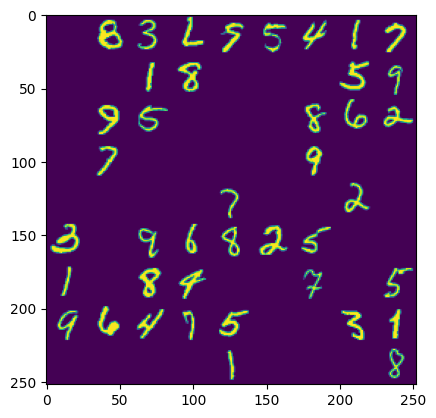

In [ ]:
# @title Visualised to check of  exctracted  array is  correct of not.
num1 = 0
resulting_arrays[num1],plt.imshow(data1[num1])

In [ ]:
# @title Saved and Downloaded extracted arrays of UNSOLVED Sudoku images

# Calculate and display the processing time
import numpy as np
from google.colab import files# Save the array to an .npy file

np.save('train_unsolved_sudoku.npy', resulting_arrays)

# Download the saved .npy file
files.download('train_unsolved_sudoku.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# @title Extraction of train label dataset (The Solved Sudoku)
start_time = time.time()

# Parameters for processing Sudoku images
window_size = 28
step_size = 28
confidence_threshold = 0.7
resulting_arrays1 = []

# Function to update Sudoku grid
def update_sudoku_grid(grid, row, col, digit):
    # Update the grid with a predicted digit at specified row and column
    if row < 9 and col < 9:
        grid[row][col] = digit

# Load Sudoku image data
data = chunk2

# Process each Sudoku image
for idx, sudoku_image in enumerate(data):
    print(f"Processing Image {idx + 1}/{len(data)}")
    sudoku_grid = np.zeros((9, 9), dtype=np.uint8)

    # Extract windows and predict digits within the Sudoku image
    for y in range(0, sudoku_image.shape[0] - window_size + 1, step_size):
        for x in range(0, sudoku_image.shape[1] - window_size + 1, step_size):
            window = sudoku_image[y:y + window_size, x:x + window_size]
            window = window.reshape(-1, 28 * 28)
            window = window.astype('float32') #/ 255.0

            # Convert the window data to tensors for model input
            window_tensor = torch.from_numpy(window)
            window_tensor = window_tensor.view(-1, 1, 28, 28)

            # Make predictions using the pre-trained model
            with torch.no_grad():
                predictions = pretrained_model(window_tensor)
                predicted_digit = torch.argmax(predictions, dim=1)
                confidence = torch.max(torch.softmax(predictions, dim=1))

            grid_row = y // (sudoku_image.shape[0] // 9)
            grid_col = x // (sudoku_image.shape[1] // 9)
            update_sudoku_grid(sudoku_grid, grid_row, grid_col, predicted_digit.item())

            # # Apply confidence threshold to predicted digits
            # if confidence > confidence_threshold:
            #     # Calculate the position in the Sudoku grid and update the grid
            #     grid_row = y // (sudoku_image.shape[0] // 9)
            #     grid_col = x // (sudoku_image.shape[1] // 9)
            #     update_sudoku_grid(sudoku_grid, grid_row, grid_col, predicted_digit.item())

    resulting_arrays1.append(sudoku_grid)

# Calculate and display the processing time
end_time = time.time()
time_difference_seconds = end_time - start_time
time_difference_minutes = time_difference_seconds / 60
print("Time taken: {:.2f} minutes".format(time_difference_minutes))


Streaming output truncated to the last 5000 lines.
Processing Image 45002/50000
Processing Image 45003/50000
Processing Image 45004/50000
Processing Image 45005/50000
Processing Image 45006/50000
Processing Image 45007/50000
Processing Image 45008/50000
Processing Image 45009/50000
Processing Image 45010/50000
Processing Image 45011/50000
Processing Image 45012/50000
Processing Image 45013/50000
Processing Image 45014/50000
Processing Image 45015/50000
Processing Image 45016/50000
Processing Image 45017/50000
Processing Image 45018/50000
Processing Image 45019/50000
Processing Image 45020/50000
Processing Image 45021/50000
Processing Image 45022/50000
Processing Image 45023/50000
Processing Image 45024/50000
Processing Image 45025/50000
Processing Image 45026/50000
Processing Image 45027/50000
Processing Image 45028/50000
Processing Image 45029/50000
Processing Image 45030/50000
Processing Image 45031/50000
Processing Image 45032/50000
Processing Image 45033/50000
Processing Image 4503

In [ ]:
# @title Shape of Extracted array Dataset
np.array(resulting_arrays1).shape

(50000, 9, 9)

(array([[6, 8, 3, 2, 9, 5, 4, 1, 7],
        [4, 2, 1, 8, 6, 7, 3, 5, 9],
        [7, 9, 5, 5, 4, 1, 8, 6, 2],
        [5, 7, 2, 1, 3, 4, 9, 8, 6],
        [8, 4, 6, 5, 7, 7, 1, 2, 3],
        [3, 1, 9, 6, 8, 2, 5, 7, 4],
        [1, 3, 8, 4, 2, 6, 7, 9, 5],
        [9, 6, 4, 7, 5, 3, 2, 3, 1],
        [2, 8, 7, 9, 1, 3, 6, 4, 8]], dtype=uint8),
 <matplotlib.image.AxesImage at 0x7e3b6e82a6b0>)

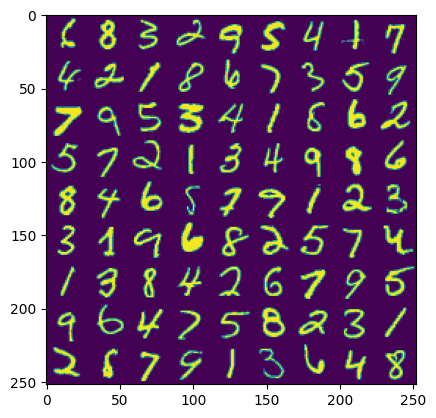

In [ ]:
# @title Visualised to check of  exctracted  array is  correct of not.
num2 = 0
resulting_arrays1[num2],plt.imshow(data2[num2])

In [ ]:
# @title Saved and Downloaded extracted arrays of SOLVED Sudoku images
# Save the array to an .npy file
np.save('train_solved_sudoku.npy', resulting_arrays1)

# Download the saved .npy file
files.download('train_solved_sudoku.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(array([[0, 6, 3, 2, 9, 5, 4, 1, 7],
        [0, 0, 1, 8, 0, 0, 0, 5, 9],
        [0, 9, 5, 0, 0, 0, 8, 6, 2],
        [0, 7, 0, 0, 0, 0, 9, 0, 0],
        [0, 0, 0, 0, 7, 0, 0, 2, 0],
        [3, 0, 9, 6, 8, 2, 5, 0, 0],
        [1, 0, 8, 4, 0, 0, 7, 0, 5],
        [9, 6, 4, 7, 5, 0, 0, 3, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 8]], dtype=uint8),
 array([[6, 8, 3, 2, 9, 5, 4, 1, 7],
        [4, 2, 1, 8, 6, 7, 3, 5, 9],
        [7, 9, 5, 5, 4, 1, 8, 6, 2],
        [5, 7, 2, 1, 3, 4, 9, 8, 6],
        [8, 4, 6, 5, 7, 7, 1, 2, 3],
        [3, 1, 9, 6, 8, 2, 5, 7, 4],
        [1, 3, 8, 4, 2, 6, 7, 9, 5],
        [9, 6, 4, 7, 5, 3, 2, 3, 1],
        [2, 8, 7, 9, 1, 3, 6, 4, 8]], dtype=uint8))

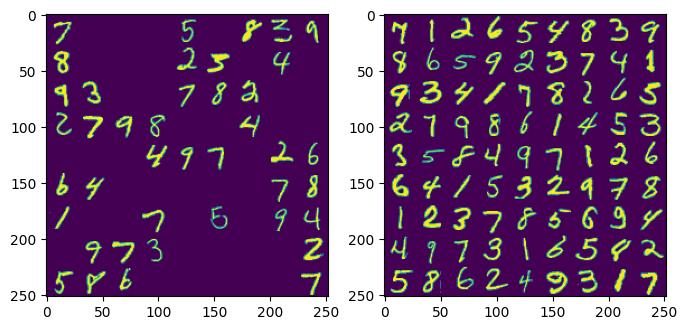

In [ ]:
# @title Final Side by side visualisation of extracted images

# Plotting
plt.figure(figsize=(8, 4))

ind = 2
# Plotting Loss
plt.subplot(1, 2, 1)
plt.imshow(data1[ind])

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.imshow(data2[ind])

resulting_arrays[num1],resulting_arrays1[num2]

In [ ]:
# @title Chunk of  the  Test dataset.
chunk3 = data3[:]

In [ ]:
# @title Extraction of TEST dataset (The unsolved Sudoku)
start_time = time.time()

# Parameters for processing Sudoku images
window_size = 28
step_size = 28
confidence_threshold = 0.7
resulting_arrays2 = []

# Function to update Sudoku grid
def update_sudoku_grid(grid, row, col, digit):
    # Update the grid with a predicted digit at specified row and column
    if row < 9 and col < 9:
        grid[row][col] = digit

# Load Sudoku image data
data = chunk3

# Process each Sudoku image
for idx, sudoku_image in enumerate(data):
    print(f"Processing Image {idx + 1}/{len(data)}")
    sudoku_grid = np.zeros((9, 9), dtype=np.uint8)

    # Extract windows and predict digits within the Sudoku image
    for y in range(0, sudoku_image.shape[0] - window_size + 1, step_size):
        for x in range(0, sudoku_image.shape[1] - window_size + 1, step_size):
            window = sudoku_image[y:y + window_size, x:x + window_size]
            window = window.reshape(-1, 28 * 28)
            window = window.astype('float32') #/ 255.0

            # Convert the window data to tensors for model input
            window_tensor = torch.from_numpy(window)
            window_tensor = window_tensor.view(-1, 1, 28, 28)

            # Make predictions using the pre-trained model
            with torch.no_grad():
                predictions = pretrained_model(window_tensor)
                predicted_digit = torch.argmax(predictions, dim=1)
                confidence = torch.max(torch.softmax(predictions, dim=1))

            grid_row = y // (sudoku_image.shape[0] // 9)
            grid_col = x // (sudoku_image.shape[1] // 9)
            update_sudoku_grid(sudoku_grid, grid_row, grid_col, predicted_digit.item())

            # # Apply confidence threshold to predicted digits
            # if confidence > confidence_threshold:
            #     # Calculate the position in the Sudoku grid and update the grid
            #     grid_row = y // (sudoku_image.shape[0] // 9)
            #     grid_col = x // (sudoku_image.shape[1] // 9)
            #     update_sudoku_grid(sudoku_grid, grid_row, grid_col, predicted_digit.item())

    resulting_arrays2.append(sudoku_grid)

# Calculate and display the processing time
end_time = time.time()
time_difference_seconds = end_time - start_time
time_difference_minutes = time_difference_seconds / 60
print("Time taken: {:.2f} minutes".format(time_difference_minutes))

Streaming output truncated to the last 5000 lines.
Processing Image 5002/10000
Processing Image 5003/10000
Processing Image 5004/10000
Processing Image 5005/10000
Processing Image 5006/10000
Processing Image 5007/10000
Processing Image 5008/10000
Processing Image 5009/10000
Processing Image 5010/10000
Processing Image 5011/10000
Processing Image 5012/10000
Processing Image 5013/10000
Processing Image 5014/10000
Processing Image 5015/10000
Processing Image 5016/10000
Processing Image 5017/10000
Processing Image 5018/10000
Processing Image 5019/10000
Processing Image 5020/10000
Processing Image 5021/10000
Processing Image 5022/10000
Processing Image 5023/10000
Processing Image 5024/10000
Processing Image 5025/10000
Processing Image 5026/10000
Processing Image 5027/10000
Processing Image 5028/10000
Processing Image 5029/10000
Processing Image 5030/10000
Processing Image 5031/10000
Processing Image 5032/10000
Processing Image 5033/10000
Processing Image 5034/10000
Processing Image 5035/100

In [ ]:
# @title Shape of Extracted array Dataset
np.array(resulting_arrays2).shape

(10000, 9, 9)

(array([[9, 0, 2, 7, 0, 0, 8, 8, 3],
        [7, 6, 1, 4, 0, 0, 0, 2, 5],
        [0, 8, 0, 0, 0, 0, 0, 7, 0],
        [6, 0, 7, 0, 9, 5, 0, 0, 0],
        [9, 1, 0, 6, 0, 0, 0, 5, 4],
        [2, 5, 0, 0, 7, 0, 6, 0, 0],
        [8, 0, 0, 5, 0, 0, 1, 0, 7],
        [5, 0, 0, 8, 0, 1, 0, 9, 0],
        [1, 3, 6, 0, 2, 7, 5, 0, 0]], dtype=uint8),
 <matplotlib.image.AxesImage at 0x7e3b6e2bebf0>)

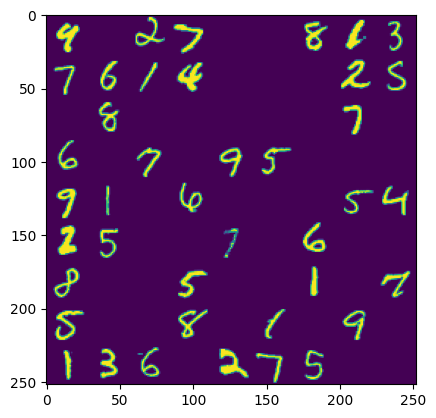

In [ ]:
# @title Visualised to check of  exctracted  array is  correct of not.
num3 = 0
resulting_arrays2[num3],plt.imshow(data3[num3])

In [ ]:
# @title Saved and Downloaded extracted arrays of UNSOLVED Sudoku images from TEST IMAGES

# Save the array to an .npy file
np.save('test_unsolved_sudoku.npy', resulting_arrays2)

# Download the saved .npy file
files.download('test_unsolved_sudoku.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 🔹 **Trained the model which can solve partially solved  Sudoku puzzle**.
### Using  extracted  datasets where  each element is  having shape (9,9).

In [ ]:
# @title Imported necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title Loaded above extracted **input** and **label** training data with a shape of (50000, 9, 9) both.

# Load data
path_unsolved = '/content/train_unsolved_sudoku.npy'
data_unsolved = np.load(path_unsolved)

path_solved = '/content/train_solved_sudoku.npy'
data_solved = np.load(path_solved)

In [ ]:
# @title Well recognised datasets
# path = '/content/drive/MyDrive/train_unsolved_sudoku (1).npy'
# data_unsolved = np.load(path)

# path2 = '/content/drive/MyDrive/train_solved_sudoku (1).npy'
# data_solved = np.load(path2)

# path3 = '/content/drive/MyDrive/test_unsolved_sudoku (3).npy'
# test_data_without_zeros = np.load(path3)

In [ ]:
# @title Removed all those pairs of Puzzles, whose lable data(solved puzzle) was containing 0.

# Identify and remove grids with zeros
contain_zeros = np.any(data_solved == 0, axis=(1, 2))
indices_with_zeros = np.where(contain_zeros)[0]

unsolved_data_cleaned = np.delete(data_unsolved, indices_with_zeros, axis=0)
sudoku_grids_cleaned = np.delete(data_solved, indices_with_zeros, axis=0)
removed_count = np.sum(contain_zeros)

# Display information
print("Original number of Sudoku grids:", data_solved.shape[0])
print("Number of grids removed:", removed_count)
print("Remaining number of Sudoku grids in unsolved_data:", unsolved_data_cleaned.shape[0])
print("Remaining number of Sudoku grids in sudoku_grids:", sudoku_grids_cleaned.shape[0])

Original number of Sudoku grids: 50000
Number of grids removed: 0
Remaining number of Sudoku grids in unsolved_data: 50000
Remaining number of Sudoku grids in sudoku_grids: 50000


In [ ]:
# @title Conversion in Tensors, Data Split & DataLoader

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(unsolved_data_cleaned, dtype=torch.float32) / 9 - 0.5
y_train_tensor = torch.tensor(sudoku_grids_cleaned - 1, dtype=torch.int64).view(-1, 81)

# Split the data into training and validation sets
train_size = int(0.8 * len(X_train_tensor))
X_train, X_val = X_train_tensor[:train_size], X_train_tensor[train_size:]
y_train, y_val = y_train_tensor[:train_size], y_train_tensor[train_size:]

# DataLoader for training and validation sets
batch_size = 64
train_dataset = [(X_train[i], y_train[i]) for i in range(len(X_train))]
val_dataset = [(X_val[i], y_val[i]) for i in range(len(X_val))]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# @title Model architecture

# Model definition
class SudokuSolver(nn.Module):
    def __init__(self):
        super(SudokuSolver, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=1)
        self.fc1 = nn.Linear(128 * 9 * 9, 81 * 9)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        return self.fc1(x.view(x.size(0), -1)).view(-1, 9)

# Instantiate model and move to GPU if available
model = SudokuSolver()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SudokuSolver(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=10368, out_features=729, bias=True)
)

In [ ]:
# @title Set up optimizer and loss function

import matplotlib.pyplot as plt

# Set up optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Move model to the appropriate device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Lists to store metrics for plotting
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
epochs = 5
for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for puzzles, solutions in train_loader:
        puzzles, solutions = puzzles.to(device), solutions.to(device)

        optimizer.zero_grad()
        outputs = model(puzzles.unsqueeze(1))
        loss = criterion(outputs, solutions.view(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct_train += (torch.max(outputs, dim=1)[1] == solutions.view(-1)).sum().item()
        total_train += solutions.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0

    with torch.no_grad():
        for puzzles, solutions in val_loader:
            puzzles, solutions = puzzles.to(device), solutions.to(device)

            outputs = model(puzzles.unsqueeze(1))
            val_loss += criterion(outputs, solutions.view(-1)).item()

            correct_val += (torch.max(outputs, dim=1)[1] == solutions.view(-1)).sum().item()
            total_val += solutions.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}: Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch 1: Train Loss: 1.5047, Train Accuracy: 35.6948, Validation Loss: 0.8850, Validation Accuracy: 56.6281
Epoch 2: Train Loss: 0.7280, Train Accuracy: 60.8653, Validation Loss: 0.6655, Validation Accuracy: 62.1765
Epoch 3: Train Loss: 0.5867, Train Accuracy: 64.6922, Validation Loss: 0.6336, Validation Accuracy: 62.7603
Epoch 4: Train Loss: 0.5171, Train Accuracy: 66.8718, Validation Loss: 0.6457, Validation Accuracy: 62.5218
Epoch 5: Train Loss: 0.4487, Train Accuracy: 69.1578, Validation Loss: 0.6856, Validation Accuracy: 61.8367


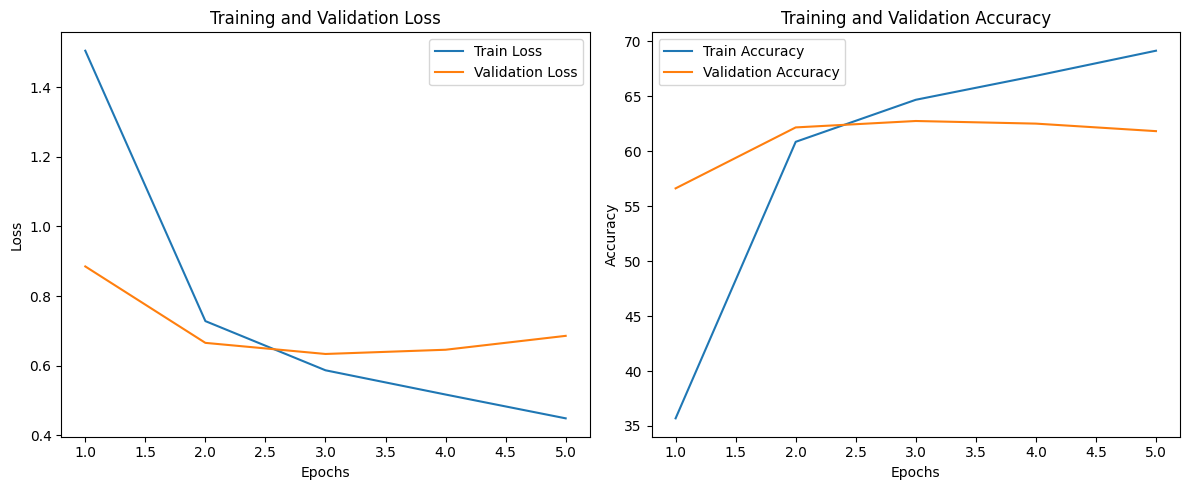

In [ ]:
# @title Plotted for Training loass and Accuracy.

# Plotting
plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### 🔹 **Predicted the  test dataset.**

In [ ]:
# @title Solution prediction for TEST data

# Load the test data
path_test = '/content/test_unsolved_sudoku.npy'
test_data_without_zeros = np.load(path_test)

# Create a DataFrame for predictions
indexes, labels = [], []

# Make predictions
model.eval()

for i, puzzle in enumerate(test_data_without_zeros):
    puzzle_str = ''.join(map(str, puzzle.flatten()))
    with torch.no_grad():
        puzzle_tensor = torch.tensor([int(p) for p in puzzle_str], dtype=torch.float32).reshape(1, 1, 9, 9) / 9 - 0.5
        puzzle_tensor = puzzle_tensor.to(device)
        solution = model(puzzle_tensor).argmax(dim=1).view(9, 9) + 1
        predictions = solution.cpu().numpy()

    for row in range(9):
        for col in range(9):
            index = str(i) + "_" + str(row) + str(col)
            indexes.append(index)
            labels.append(predictions[row, col])

# Save predictions to a CSV file
df_test_predictions = pd.DataFrame({"id": indexes, "values": labels})

In [ ]:
# @title Saved CSV file.
df_test_predictions.to_csv("solved_Submission.csv", index=False)

In [ ]:
# @title Preview of Submission File
pd.read_csv('/content/solved_Submission.csv')

,id,values
0,0_00,4
1,0_01,4
2,0_02,2
3,0_03,7
4,0_04,1
...,...,...
809995,9999_84,8
809996,9999_85,8
809997,9999_86,3
809998,9999_87,9


# ✌ **Second approch towards the solution.**

**Steps in TASK 1:**

1. Loaded **MNIST dataset** with transformations for training and validation.
2. Defined a simple neural network architecture for digit recognition.
3. Trained the model over 15 epochs using training and validation datasets.
4. Saved the trained model weights as 'mnist_cnn_model.pth'.
5. Imported necessary libraries for digit recognition of test data.
6. Defined a neural network architecture and loaded pre-trained model on MNIST data.
7. Processed test Sudoku images, predicted digits, and updated Sudoku grids.
8. Created a submission file in CSV format for the predicted digits.

**Steps in TASK 2:**

1. Imported libraries: torch, numpy, csv, time, torch.nn, matplotlib.pyplot, Google Colab utilities.
2. Loaded 50,000 training pairs of partially and completely filled Sudoku images.
3. Created chunks of training data and labels, and loaded test Sudoku images.
4. Loaded pre-trained weights for digit recognition from the MNIST task.
5. Extracted unsolved train, solved train and unsolved test Sudoku grids from training images, labeled training images and test images respectively using predefined windows.
6. Trained the SudokuSolver model, validated, and plotted training metrics (loss and accuracy).
7. Loaded the test data and made predictions using the trained model.
8. Saved the predictions to a CSV file named "solved_Submission.csv".
9. Created a preview of the submission file.

## ✅ **TASK 1**


1. TASK Origin: This Sudoku-solving TASK is MAI program's Artificial Neural Networks and Cognitive Models course.

2. Two Tasks: The project is divided into two tasks. Task 1 involves training a model to interpret a Sudoku puzzle and identify digits and their positions. Task 2 focuses on training a model to solve the Sudoku puzzle by completing empty cells using standard rules.

3. Puzzle Description: The Sudoku puzzle is a 9x9 grid with digits from 1 to 9, following Sudoku rules. Each column, row, and 3x3 subgrid must contain all digits. The provided incomplete grid has 40 empty cells.

4. Model Objective (Task 1): The goal is to train a model that recognizes filled digits within the puzzle and their corresponding positions in the grid. The model should provide a list of cells containing digits.

5. Training Data: A dataset of 50,000 training images of partially solved Sudoku puzzles is provided, along with labels indicating coordinates of 41 filled positions in each image.

6. Test Set: The model's performance is evaluated on a test set comprising 10,000 images, and its ability to recognize digits and positions is assessed.

### 🔹 **MNIST dataset loaded and trained model.**



In [ ]:
# @title MNIST Dataset trained

from google.colab import drive
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Mount Google Drive to access files
drive.mount('/content/drive')

# Load MNIST training dataset with transformation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Load MNIST validation dataset with the same transformation
valset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)

# Define a simple neural network architecture
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

model = ANN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 15
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    accuracy_train = correct_train / total_train

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    # Lists to store predictions and ground truth labels during validation
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in valloader:
            inputs_val, labels_val = data
            outputs_val = model(inputs_val)

            _, predicted_val = torch.max(outputs_val.data, 1)

            all_preds.extend(predicted_val.cpu().numpy())
            all_labels.extend(labels_val.cpu().numpy())

            loss_val = criterion(outputs_val, labels_val)
            running_val_loss += loss_val.item()

            total_val += labels_val.size(0)
            correct_val += (predicted_val == labels_val).sum().item()

    accuracy_val = correct_val / total_val

    print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {running_loss / len(trainloader):.4f}, Train Accuracy: {accuracy_train:.4f}, Val Loss: {running_val_loss / len(valloader):.4f}, Val Accuracy: {accuracy_val:.4f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch [1/15], Train Loss: 0.3963, Train Accuracy: 0.8813, Val Loss: 0.2276, Val Accuracy: 0.9315
Epoch [2/15], Train Loss: 0.1888, Train Accuracy: 0.9440, Val Loss: 0.1506, Val Accuracy: 0.9538
Epoch [3/15], Train Loss: 0.1392, Train Accuracy: 0.9572, Val Loss: 0.1282, Val Accuracy: 0.9603
Epoch [4/15], Train Loss: 0.1111, Train Accuracy: 0.9655, Val Loss: 0.1212, Val Accuracy: 0.9580
Epoch [5/15], Train Loss: 0.0944, Train Accuracy: 0.9702, Val Loss: 0.1080, Val Accuracy: 0.9662
Epoch [6/15], Train Loss: 0.0833, Train Accuracy: 0.9738, Val Loss: 0.1156, Val Accuracy: 0.9644
Epoch [7/15], Train Loss: 0.0747, Train Accuracy: 0.9760, Val Loss: 0.0969, Val Accuracy: 0.9695
Epoch [8/15], Train Loss: 0.0686, Train Accuracy: 0.9773, Val Loss: 0.0914, Val Accuracy: 0.9718
Epoch [9/15], Train Loss: 0.0602, Train Accuracy: 0.9807, Val Loss: 0.0969, Val Accuracy: 0.970

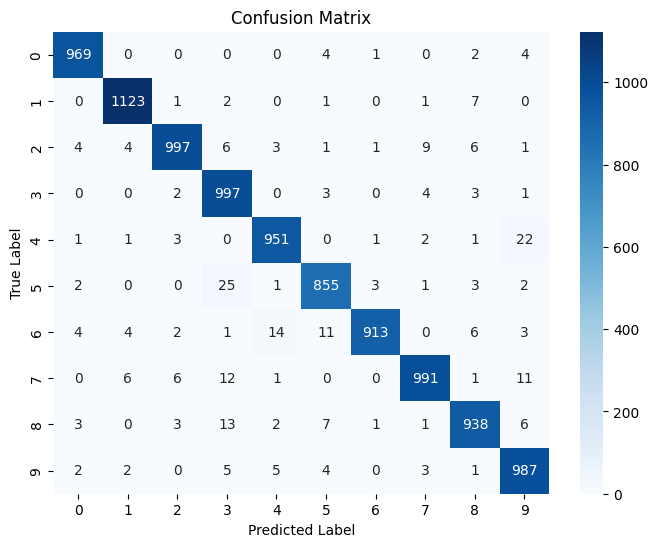

In [ ]:
# @title Calculate confusion matrix after training
conf_matrix = np.zeros((10, 10), dtype=np.int64)

for pred, label in zip(all_preds, all_labels):
    conf_matrix[label, pred] += 1

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# @title Save the trained model
torch.save(model.state_dict(), 'mnist_cnn_model.pth')

### 🔹 **Digit Recognition of TEST data**

In [ ]:
# @title Imported  necesarry libraries.
import numpy as np
import pandas as pd

In [ ]:
# @title Mounted Google Drive to access files
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title Load Sudoku image data and labels using NumPy
testimages = np.load('/content/drive/MyDrive/Sudoko Dataset Task 1/test/imgs.npy')

In [ ]:
# @title Chunk of test image dataset
test_images = testimages[:]

In [ ]:
# @title  Digit Recognition of TEST data
import torch
import numpy as np
import csv
import time
import torch.nn as nn

start_time = time.time()
# Define a simple neural network architecture
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

# Load the pre-trained weights for SimpleNN model
pretrained_model = ANN()
pretrained_model.load_state_dict(torch.load('/content/mnist_cnn_model.pth'))
pretrained_model.eval()

# Parameters for processing Sudoku images
window_size = 28
step_size = 28
confidence_threshold = 0.7
resulting_arrays = []

# Function to update Sudoku grid
def update_sudoku_grid(grid, row, col, digit):
    # Update the grid with a predicted digit at specified row and column
    if row < 9 and col < 9:
        grid[row][col] = digit

# Load Sudoku image data
data = test_images

# Process each Sudoku image
for idx, sudoku_image in enumerate(data):
    print(f"Processing Image {idx + 1}/{len(data)}")
    sudoku_grid = np.zeros((9, 9), dtype=np.uint8)

    # Extract windows and predict digits within the Sudoku image
    for y in range(0, sudoku_image.shape[0] - window_size + 1, step_size):
        for x in range(0, sudoku_image.shape[1] - window_size + 1, step_size):
            window = sudoku_image[y:y + window_size, x:x + window_size]
            window = window.reshape(-1, 28 * 28)
            window = window.astype('float32') #/ 255.0

            # Convert the window data to tensors for model input
            window_tensor = torch.from_numpy(window)
            window_tensor = window_tensor.view(-1, 1, 28, 28)

            # Make predictions using the pre-trained model
            with torch.no_grad():
                predictions = pretrained_model(window_tensor)
                predicted_digit = torch.argmax(predictions, dim=1)
                confidence = torch.max(torch.softmax(predictions, dim=1))

            grid_row = y // (sudoku_image.shape[0] // 9)
            grid_col = x // (sudoku_image.shape[1] // 9)
            update_sudoku_grid(sudoku_grid, grid_row, grid_col, predicted_digit.item())

            # # Apply confidence threshold to predicted digits
            # if confidence > confidence_threshold:
            #     # Calculate the position in the Sudoku grid and update the grid
            #     grid_row = y // (sudoku_image.shape[0] // 9)
            #     grid_col = x // (sudoku_image.shape[1] // 9)
            #     update_sudoku_grid(sudoku_grid, grid_row, grid_col, predicted_digit.item())

    resulting_arrays.append(sudoku_grid)


Streaming output truncated to the last 5000 lines.
Processing Image 5001/10000
Processing Image 5002/10000
Processing Image 5003/10000
Processing Image 5004/10000
Processing Image 5005/10000
Processing Image 5006/10000
Processing Image 5007/10000
Processing Image 5008/10000
Processing Image 5009/10000
Processing Image 5010/10000
Processing Image 5011/10000
Processing Image 5012/10000
Processing Image 5013/10000
Processing Image 5014/10000
Processing Image 5015/10000
Processing Image 5016/10000
Processing Image 5017/10000
Processing Image 5018/10000
Processing Image 5019/10000
Processing Image 5020/10000
Processing Image 5021/10000
Processing Image 5022/10000
Processing Image 5023/10000
Processing Image 5024/10000
Processing Image 5025/10000
Processing Image 5026/10000
Processing Image 5027/10000
Processing Image 5028/10000
Processing Image 5029/10000
Processing Image 5030/10000
Processing Image 5031/10000
Processing Image 5032/10000
Processing Image 5033/10000
Processing Image 5034/100

### 🔹 **Created Sumbission file.**

In [ ]:
# @title Prepared content for submission in CSV format

submission_content = [['id', 'value']]
for image_id, grid in enumerate(resulting_arrays):
    for row_idx, row in enumerate(grid):
        for col_idx, cell_value in enumerate(row):
            cell_id = f"{image_id}_{row_idx}{col_idx:01}"
            submission_content.append([cell_id, cell_value])

# Write submission content to a CSV file
submission_filename = 'submission.csv'
with open(submission_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(submission_content)

print(f"Submission file '{submission_filename}' has been created.")

# Calculate and display the processing time
end_time = time.time()
time_difference_seconds = end_time - start_time
time_difference_minutes = time_difference_seconds / 60
print("Time taken: {:.2f} minutes".format(time_difference_minutes))

Submission file 'submission.csv' has been created.
Time taken: 2.43 minutes


In [ ]:
# @title Predicted digits and their position
pd.read_csv('/content/submission.csv')

,id,value
0,0_00,2
1,0_01,8
2,0_02,7
3,0_03,8
4,0_04,1
...,...,...
809995,9999_84,3
809996,9999_85,5
809997,9999_86,2
809998,9999_87,8


(array([[2, 8, 7, 8, 1, 3, 4, 8, 8],
        [8, 8, 6, 8, 4, 9, 2, 3, 5],
        [9, 8, 3, 8, 8, 6, 8, 8, 8],
        [8, 9, 8, 8, 5, 8, 8, 2, 8],
        [1, 8, 8, 9, 7, 8, 5, 6, 8],
        [8, 3, 8, 8, 8, 2, 8, 8, 8],
        [3, 6, 1, 9, 8, 8, 7, 8, 8],
        [8, 8, 8, 8, 8, 7, 8, 1, 8],
        [4, 8, 2, 8, 8, 8, 3, 8, 8]], dtype=uint8),
 <matplotlib.image.AxesImage at 0x7fced4c01db0>)

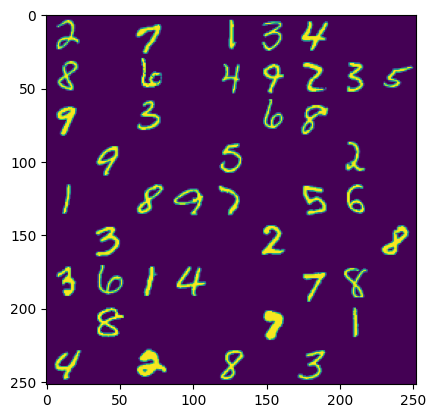

In [ ]:
# @title Compared the Predicted Grid.
import matplotlib.pyplot as plt

resulting_arrays[0], plt.imshow(testimages[0])

## ✅ **TASK 2**

1. Description: This task involves training a model to complete Sudoku puzzles from partially filled images, building on Task 1's Sudoku image description.

2. Training Data: A set of 50,000 pairs of partially and completely filled Sudoku images is provided for model training.

3. Task: We have to train a model to complete 10,000 test Sudoku images that are partially filled. The model's performance is evaluated based on its ability to accurately fill in the missing cells in these test images.

### 🔹 **Loaded the Data of shape** (50000,252,252).

In [ ]:
# @title Imported important libraries
from google.colab import drive
import torch
import numpy as np
import csv
import time
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
# @title Mounted Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title Loaded Sudoku image data
path = '/content/drive/MyDrive/Sudoko Dataset Task 2/Train/imgs.npy'
data1 = np.load(path)

In [ ]:
# @title Created some chunk of dataset for training
chunk1 = data1[:]

In [ ]:
# @title Loaded Sudoku label data
path2 = '/content/drive/MyDrive/Sudoko Dataset Task 2/Train/labels.npy'
data2 = np.load(path2)

In [ ]:
# @title Created some chunk of dataset for training
chunk2 = data2[:]

In [ ]:
# @title Load Sudoku label test data
path3 = '/content/drive/MyDrive/Sudoko Dataset Task 2/Test/imgs.npy'
data3 = np.load(path3)

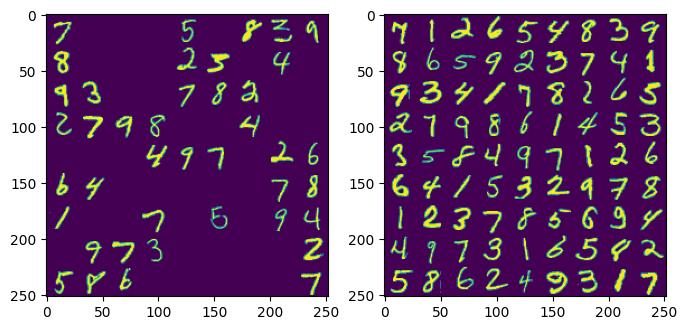

In [ ]:
# @title Visualization of image
# Plotting
plt.figure(figsize=(8, 4))

index = 2
# Plotting Loss
plt.subplot(1, 2, 1)
plt.imshow(data1[index])

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.imshow(data2[index])

### 🔹 **Extracted of Datasets FOR  TASK 2....**

In [ ]:
# @title Imported the  trained  model and  architecture from above.
# Define a simple neural network architecture
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

# Load the pre-trained weights for SimpleNN model
pretrained_model = ANN()
pretrained_model.load_state_dict(torch.load('/content/mnist_cnn_model.pth'))
pretrained_model.eval()

ANN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): LogSoftmax(dim=1)
)

In [ ]:
# @title Extraction of train data set (The unsolved Sudoku)
start_time = time.time()

# Parameters for processing Sudoku images
window_size = 28
step_size = 28
confidence_threshold = 0.7
resulting_arrays = []

# Function to update Sudoku grid
def update_sudoku_grid(grid, row, col, digit):
    # Update the grid with a predicted digit at specified row and column
    if row < 9 and col < 9:
        grid[row][col] = digit

# Load Sudoku image data
data = chunk1

# Process each Sudoku image
for idx, sudoku_image in enumerate(data):
    print(f"Processing Image {idx + 1}/{len(data)}")
    sudoku_grid = np.zeros((9, 9), dtype=np.uint8)

    # Extract windows and predict digits within the Sudoku image
    for y in range(0, sudoku_image.shape[0] - window_size + 1, step_size):
        for x in range(0, sudoku_image.shape[1] - window_size + 1, step_size):
            window = sudoku_image[y:y + window_size, x:x + window_size]
            window = window.reshape(-1, 28 * 28)
            window = window.astype('float32') #/ 255.0

            # Convert the window data to tensors for model input
            window_tensor = torch.from_numpy(window)
            window_tensor = window_tensor.view(-1, 1, 28, 28)

            # Make predictions using the pre-trained model
            with torch.no_grad():
                predictions = pretrained_model(window_tensor)
                predicted_digit = torch.argmax(predictions, dim=1)
                confidence = torch.max(torch.softmax(predictions, dim=1))

            grid_row = y // (sudoku_image.shape[0] // 9)
            grid_col = x // (sudoku_image.shape[1] // 9)
            update_sudoku_grid(sudoku_grid, grid_row, grid_col, predicted_digit.item())

            # # Apply confidence threshold to predicted digits
            # if confidence > confidence_threshold:
            #     # Calculate the position in the Sudoku grid and update the grid
            #     grid_row = y // (sudoku_image.shape[0] // 9)
            #     grid_col = x // (sudoku_image.shape[1] // 9)
            #     update_sudoku_grid(sudoku_grid, grid_row, grid_col, predicted_digit.item())

    resulting_arrays.append(sudoku_grid)

# Calculate and display the processing time
end_time = time.time()
time_difference_seconds = end_time - start_time
time_difference_minutes = time_difference_seconds / 60
print("Time taken: {:.2f} minutes".format(time_difference_minutes))

Streaming output truncated to the last 5000 lines.
Processing Image 45002/50000
Processing Image 45003/50000
Processing Image 45004/50000
Processing Image 45005/50000
Processing Image 45006/50000
Processing Image 45007/50000
Processing Image 45008/50000
Processing Image 45009/50000
Processing Image 45010/50000
Processing Image 45011/50000
Processing Image 45012/50000
Processing Image 45013/50000
Processing Image 45014/50000
Processing Image 45015/50000
Processing Image 45016/50000
Processing Image 45017/50000
Processing Image 45018/50000
Processing Image 45019/50000
Processing Image 45020/50000
Processing Image 45021/50000
Processing Image 45022/50000
Processing Image 45023/50000
Processing Image 45024/50000
Processing Image 45025/50000
Processing Image 45026/50000
Processing Image 45027/50000
Processing Image 45028/50000
Processing Image 45029/50000
Processing Image 45030/50000
Processing Image 45031/50000
Processing Image 45032/50000
Processing Image 45033/50000
Processing Image 4503

In [ ]:
# @title Shape of Extracted array Dataset
np.array(resulting_arrays).shape

(50000, 9, 9)

(array([[8, 8, 3, 2, 9, 5, 4, 1, 7],
        [8, 8, 1, 8, 8, 8, 8, 5, 9],
        [8, 9, 5, 8, 8, 8, 8, 6, 2],
        [8, 7, 8, 8, 8, 8, 9, 8, 8],
        [8, 8, 8, 8, 7, 8, 8, 2, 8],
        [3, 8, 9, 6, 8, 2, 5, 8, 8],
        [1, 8, 8, 9, 8, 8, 7, 8, 5],
        [9, 6, 4, 7, 5, 8, 8, 3, 1],
        [8, 8, 8, 8, 1, 8, 8, 8, 8]], dtype=uint8),
 <matplotlib.image.AxesImage at 0x7fce812c7c10>)

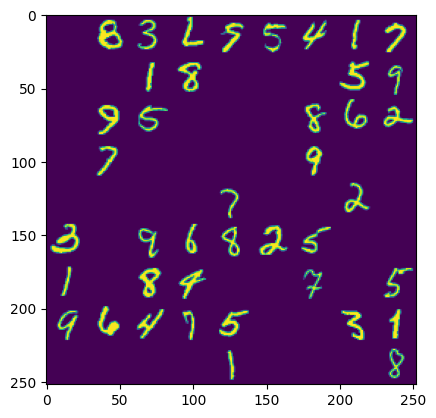

In [ ]:
# @title Visualised to check of  exctracted  array is  correct of not.
num1 = 0
resulting_arrays[num1],plt.imshow(data1[num1])

In [ ]:
# @title Saved and Downloaded extracted arrays of UNSOLVED Sudoku images

# Calculate and display the processing time
import numpy as np
from google.colab import files# Save the array to an .npy file

np.save('train_unsolved_sudoku.npy', resulting_arrays)

# Download the saved .npy file
files.download('train_unsolved_sudoku.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# @title Extraction of train label dataset (The Solved Sudoku)
start_time = time.time()

# Parameters for processing Sudoku images
window_size = 28
step_size = 28
confidence_threshold = 0.7
resulting_arrays1 = []

# Function to update Sudoku grid
def update_sudoku_grid(grid, row, col, digit):
    # Update the grid with a predicted digit at specified row and column
    if row < 9 and col < 9:
        grid[row][col] = digit

# Load Sudoku image data
data = chunk2

# Process each Sudoku image
for idx, sudoku_image in enumerate(data):
    print(f"Processing Image {idx + 1}/{len(data)}")
    sudoku_grid = np.zeros((9, 9), dtype=np.uint8)

    # Extract windows and predict digits within the Sudoku image
    for y in range(0, sudoku_image.shape[0] - window_size + 1, step_size):
        for x in range(0, sudoku_image.shape[1] - window_size + 1, step_size):
            window = sudoku_image[y:y + window_size, x:x + window_size]
            window = window.reshape(-1, 28 * 28)
            window = window.astype('float32') #/ 255.0

            # Convert the window data to tensors for model input
            window_tensor = torch.from_numpy(window)
            window_tensor = window_tensor.view(-1, 1, 28, 28)

            # Make predictions using the pre-trained model
            with torch.no_grad():
                predictions = pretrained_model(window_tensor)
                predicted_digit = torch.argmax(predictions, dim=1)
                confidence = torch.max(torch.softmax(predictions, dim=1))

            grid_row = y // (sudoku_image.shape[0] // 9)
            grid_col = x // (sudoku_image.shape[1] // 9)
            update_sudoku_grid(sudoku_grid, grid_row, grid_col, predicted_digit.item())

            # # Apply confidence threshold to predicted digits
            # if confidence > confidence_threshold:
            #     # Calculate the position in the Sudoku grid and update the grid
            #     grid_row = y // (sudoku_image.shape[0] // 9)
            #     grid_col = x // (sudoku_image.shape[1] // 9)
            #     update_sudoku_grid(sudoku_grid, grid_row, grid_col, predicted_digit.item())

    resulting_arrays1.append(sudoku_grid)

# Calculate and display the processing time
end_time = time.time()
time_difference_seconds = end_time - start_time
time_difference_minutes = time_difference_seconds / 60
print("Time taken: {:.2f} minutes".format(time_difference_minutes))


Streaming output truncated to the last 5000 lines.
Processing Image 45002/50000
Processing Image 45003/50000
Processing Image 45004/50000
Processing Image 45005/50000
Processing Image 45006/50000
Processing Image 45007/50000
Processing Image 45008/50000
Processing Image 45009/50000
Processing Image 45010/50000
Processing Image 45011/50000
Processing Image 45012/50000
Processing Image 45013/50000
Processing Image 45014/50000
Processing Image 45015/50000
Processing Image 45016/50000
Processing Image 45017/50000
Processing Image 45018/50000
Processing Image 45019/50000
Processing Image 45020/50000
Processing Image 45021/50000
Processing Image 45022/50000
Processing Image 45023/50000
Processing Image 45024/50000
Processing Image 45025/50000
Processing Image 45026/50000
Processing Image 45027/50000
Processing Image 45028/50000
Processing Image 45029/50000
Processing Image 45030/50000
Processing Image 45031/50000
Processing Image 45032/50000
Processing Image 45033/50000
Processing Image 4503

In [ ]:
# @title Well recognised datasets

# path = '/content/drive/MyDrive/train_unsolved_sudoku (1).npy'
# data_unsolved = np.load(path)

# path2 = '/content/drive/MyDrive/train_solved_sudoku (1).npy'
# data_solved = np.load(path2)

# path3 = '/content/drive/MyDrive/test_unsolved_sudoku (3).npy'
# test_data_without_zeros = np.load(path3)

In [ ]:
# @title Shape of Extracted array Dataset
np.array(resulting_arrays1).shape

(50000, 9, 9)

(array([[6, 8, 3, 2, 9, 5, 4, 1, 7],
        [4, 2, 1, 8, 6, 7, 5, 5, 9],
        [7, 9, 5, 5, 4, 1, 5, 6, 2],
        [5, 7, 2, 1, 3, 4, 9, 8, 6],
        [8, 4, 6, 5, 7, 9, 1, 2, 3],
        [3, 1, 9, 6, 8, 2, 5, 7, 4],
        [1, 3, 8, 4, 2, 5, 7, 9, 5],
        [9, 6, 4, 7, 5, 3, 2, 3, 1],
        [2, 5, 7, 9, 1, 3, 6, 4, 8]], dtype=uint8),
 <matplotlib.image.AxesImage at 0x7fce80ed6530>)

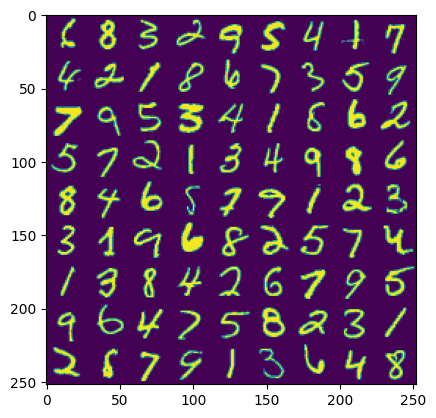

In [ ]:
# @title Visualised to check of  exctracted  array is  correct of not.
num2 = 0
resulting_arrays1[num2],plt.imshow(data2[num2])

In [ ]:
# @title Saved and Downloaded extracted arrays of SOLVED Sudoku images
# Save the array to an .npy file
np.save('train_solved_sudoku.npy', resulting_arrays1)

# Download the saved .npy file
files.download('train_solved_sudoku.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(array([[8, 8, 3, 2, 9, 5, 4, 1, 7],
        [8, 8, 1, 8, 8, 8, 8, 5, 9],
        [8, 9, 5, 8, 8, 8, 8, 6, 2],
        [8, 7, 8, 8, 8, 8, 9, 8, 8],
        [8, 8, 8, 8, 7, 8, 8, 2, 8],
        [3, 8, 9, 6, 8, 2, 5, 8, 8],
        [1, 8, 8, 9, 8, 8, 7, 8, 5],
        [9, 6, 4, 7, 5, 8, 8, 3, 1],
        [8, 8, 8, 8, 1, 8, 8, 8, 8]], dtype=uint8),
 array([[6, 8, 3, 2, 9, 5, 4, 1, 7],
        [4, 2, 1, 8, 6, 7, 5, 5, 9],
        [7, 9, 5, 5, 4, 1, 5, 6, 2],
        [5, 7, 2, 1, 3, 4, 9, 8, 6],
        [8, 4, 6, 5, 7, 9, 1, 2, 3],
        [3, 1, 9, 6, 8, 2, 5, 7, 4],
        [1, 3, 8, 4, 2, 5, 7, 9, 5],
        [9, 6, 4, 7, 5, 3, 2, 3, 1],
        [2, 5, 7, 9, 1, 3, 6, 4, 8]], dtype=uint8))

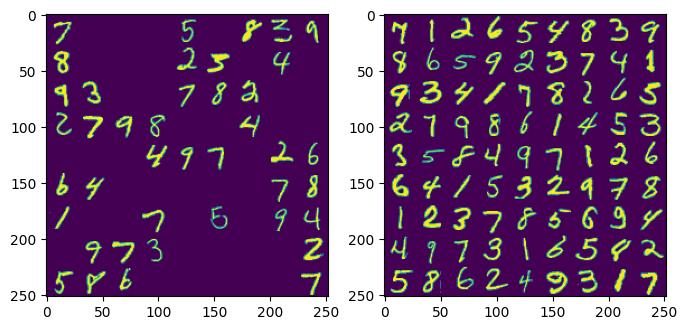

In [ ]:
# @title Final Side by side visualisation of extracted images

# Plotting
plt.figure(figsize=(8, 4))

ind = 2
# Plotting Loss
plt.subplot(1, 2, 1)
plt.imshow(data1[ind])

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.imshow(data2[ind])

resulting_arrays[num1],resulting_arrays1[num2]

In [ ]:
# @title Chunk of  the  Test dataset.
chunk3 = data3[:]

In [ ]:
# @title Extraction of TEST dataset (The unsolved Sudoku)
start_time = time.time()

# Parameters for processing Sudoku images
window_size = 28
step_size = 28
confidence_threshold = 0.7
resulting_arrays2 = []

# Function to update Sudoku grid
def update_sudoku_grid(grid, row, col, digit):
    # Update the grid with a predicted digit at specified row and column
    if row < 9 and col < 9:
        grid[row][col] = digit

# Load Sudoku image data
data = chunk3

# Process each Sudoku image
for idx, sudoku_image in enumerate(data):
    print(f"Processing Image {idx + 1}/{len(data)}")
    sudoku_grid = np.zeros((9, 9), dtype=np.uint8)

    # Extract windows and predict digits within the Sudoku image
    for y in range(0, sudoku_image.shape[0] - window_size + 1, step_size):
        for x in range(0, sudoku_image.shape[1] - window_size + 1, step_size):
            window = sudoku_image[y:y + window_size, x:x + window_size]
            window = window.reshape(-1, 28 * 28)
            window = window.astype('float32') #/ 255.0

            # Convert the window data to tensors for model input
            window_tensor = torch.from_numpy(window)
            window_tensor = window_tensor.view(-1, 1, 28, 28)

            # Make predictions using the pre-trained model
            with torch.no_grad():
                predictions = pretrained_model(window_tensor)
                predicted_digit = torch.argmax(predictions, dim=1)
                confidence = torch.max(torch.softmax(predictions, dim=1))

            grid_row = y // (sudoku_image.shape[0] // 9)
            grid_col = x // (sudoku_image.shape[1] // 9)
            update_sudoku_grid(sudoku_grid, grid_row, grid_col, predicted_digit.item())

            # # Apply confidence threshold to predicted digits
            # if confidence > confidence_threshold:
            #     # Calculate the position in the Sudoku grid and update the grid
            #     grid_row = y // (sudoku_image.shape[0] // 9)
            #     grid_col = x // (sudoku_image.shape[1] // 9)
            #     update_sudoku_grid(sudoku_grid, grid_row, grid_col, predicted_digit.item())

    resulting_arrays2.append(sudoku_grid)

# Calculate and display the processing time
end_time = time.time()
time_difference_seconds = end_time - start_time
time_difference_minutes = time_difference_seconds / 60
print("Time taken: {:.2f} minutes".format(time_difference_minutes))

Streaming output truncated to the last 5000 lines.
Processing Image 5002/10000
Processing Image 5003/10000
Processing Image 5004/10000
Processing Image 5005/10000
Processing Image 5006/10000
Processing Image 5007/10000
Processing Image 5008/10000
Processing Image 5009/10000
Processing Image 5010/10000
Processing Image 5011/10000
Processing Image 5012/10000
Processing Image 5013/10000
Processing Image 5014/10000
Processing Image 5015/10000
Processing Image 5016/10000
Processing Image 5017/10000
Processing Image 5018/10000
Processing Image 5019/10000
Processing Image 5020/10000
Processing Image 5021/10000
Processing Image 5022/10000
Processing Image 5023/10000
Processing Image 5024/10000
Processing Image 5025/10000
Processing Image 5026/10000
Processing Image 5027/10000
Processing Image 5028/10000
Processing Image 5029/10000
Processing Image 5030/10000
Processing Image 5031/10000
Processing Image 5032/10000
Processing Image 5033/10000
Processing Image 5034/10000
Processing Image 5035/100

In [ ]:
# @title Shape of Extracted array Dataset
np.array(resulting_arrays2).shape

(10000, 9, 9)

(array([[9, 8, 2, 7, 8, 8, 8, 5, 3],
        [7, 5, 1, 4, 8, 8, 8, 2, 5],
        [8, 8, 8, 8, 8, 8, 8, 7, 8],
        [6, 8, 7, 8, 9, 5, 8, 8, 8],
        [9, 1, 8, 6, 8, 8, 8, 5, 4],
        [2, 5, 8, 8, 7, 8, 6, 8, 8],
        [8, 8, 8, 5, 8, 8, 1, 8, 7],
        [5, 8, 8, 8, 8, 1, 8, 9, 8],
        [1, 3, 6, 8, 2, 7, 5, 8, 8]], dtype=uint8),
 <matplotlib.image.AxesImage at 0x7fce8092e3b0>)

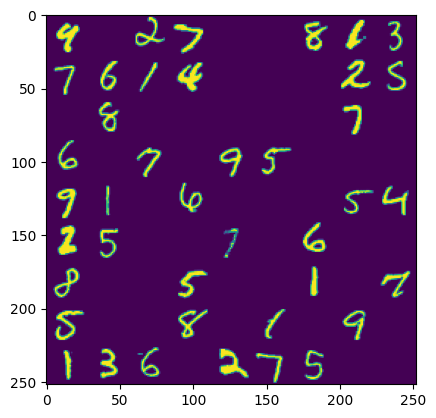

In [ ]:
# @title Visualised to check of  exctracted  array is  correct of not.
num3 = 0
resulting_arrays2[num3],plt.imshow(data3[num3])

In [ ]:
# @title Saved and Downloaded extracted arrays of UNSOLVED Sudoku images from TEST IMAGES
# Save the array to an .npy file
np.save('test_unsolved_sudoku.npy', resulting_arrays2)

# Download the saved .npy file
files.download('test_unsolved_sudoku.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 🔹 **Trained the model which can solve partially solved  Sudoku puzzle**.
### Using  extracted  datasets where  each element is  having shape (9,9).

In [ ]:
# @title Imported necessary libraries
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title Loaded above extracted **input** and **label** training data with a shape of (50000, 9, 9) both.

# Load data
path_unsolved = '/content/train_unsolved_sudoku.npy'
data_unsolved = np.load(path_unsolved)

path_solved = '/content/train_solved_sudoku.npy'
data_solved = np.load(path_solved)

# Preprocess training data
sudoku_grids = data_solved
another_data = data_unsolved

In [ ]:
# @title Well recognised datasets

# # Load training data
# path_train_unsolved = '/content/drive/MyDrive/train_unsolved_sudoku (1).npy'
# path_train_solved = '/content/drive/MyDrive/train_solved_sudoku (1).npy'

# data_unsolved = np.load(path_train_unsolved)
# data_solved = np.load(path_train_solved)

# # Preprocess training data
# sudoku_grids = data_solved
# another_data = data_unsolved

In [ ]:
# @title Removed all those pairs of Puzzles, whose lable data(solved puzzle) was containing 0.
# Remove rows with zeros from both another_data and sudoku_grids

contain_zeros = np.any(sudoku_grids == 0, axis=(1, 2))
indices_with_zeros = np.where(contain_zeros)[0]

another_data_without_zeros = np.delete(another_data, indices_with_zeros, axis=0)
sudoku_grids_without_zeros = np.delete(sudoku_grids, indices_with_zeros, axis=0)

removed_count = np.sum(contain_zeros)

# Print information about the original and processed datasets
print(f"Original number of Sudoku grids: {sudoku_grids.shape[0]}")
print(f"Number of grids removed: {removed_count}")
print(f"Remaining number of Sudoku grids in another_data: {another_data_without_zeros.shape[0]}")
print(f"Remaining number of Sudoku grids in sudoku_grids: {sudoku_grids_without_zeros.shape[0]}")

Original number of Sudoku grids: 50000
Number of grids removed: 9405
Remaining number of Sudoku grids in another_data: 40595
Remaining number of Sudoku grids in sudoku_grids: 40595


In [ ]:
# @title Conversion in Tensors, Data Split & DataLoader

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use non-zero arrays directly to create DataLoader
train_data = [(torch.tensor(puzzle, dtype=torch.float32).reshape(1, 1, 9, 9) / 9 - 0.5, torch.tensor(solution - 1, dtype=torch.int64).reshape(81)) for puzzle, solution in zip(another_data_without_zeros, sudoku_grids_without_zeros)]
train_loader = DataLoader(train_data, batch_size=640, shuffle=True)

# Validation set
train_idx = int(len(another_data_without_zeros) * 0.75)
val_data = [(torch.tensor(puzzle, dtype=torch.float32).reshape(1, 1, 9, 9) / 9 - 0.5, torch.tensor(solution - 1, dtype=torch.int64).reshape(81)) for puzzle, solution in zip(another_data_without_zeros[train_idx:], sudoku_grids_without_zeros[train_idx:])]
val_loader = DataLoader(val_data, batch_size=640, shuffle=False)

In [ ]:
# @title Model architecture

# Define the SudokuSolver model
class SudokuSolver(nn.Module):
    def __init__(self):
        super(SudokuSolver, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=1)
        self.fc1 = nn.Linear(128 * 9 * 9, 81 * 9)

    def forward(self, x):
        x = x.squeeze(1)
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = F.relu(self.conv3(x))
        x_flattened = x.view(x.size(0), -1)
        x_fc1 = self.fc1(x_flattened)
        x_reshaped = x_fc1.view(-1, 9)
        return x_reshaped

# Initialize the model, optimizer, and criterion
model = SudokuSolver().to(device)

In [ ]:
# @title Initialize the model, optimizer, and criterion

model = SudokuSolver().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Assuming train_loader and val_loader are your PyTorch data loaders
epochs = 35
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train = 0

    for puzzles, solutions in train_loader:
        puzzles = puzzles.to(device)
        solutions = solutions.to(device)
        optimizer.zero_grad()
        outputs = model(puzzles)
        loss = criterion(outputs, solutions.view(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += ((torch.max(outputs, dim=1)[1] == solutions.view(-1)).sum().item())
        total_train += solutions.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = train_correct / total_train

    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for puzzles, solutions in val_loader:
            puzzles, solutions = puzzles.to(device), solutions.to(device)
            outputs = model(puzzles)
            val_loss += criterion(outputs, solutions.view(-1)).item()

            val_correct += ((torch.max(outputs, dim=1)[1] == solutions.view(-1)).sum().item())
            total_val += solutions.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / total_val

    print(f'Epoch {epoch + 1}: Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Append losses and accuracies for plotting
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

Epoch 1: Train Loss: 2.1012, Train Accuracy: 15.3894, Validation Loss: 1.9035, Validation Accuracy: 23.6008
Epoch 2: Train Loss: 1.7067, Train Accuracy: 30.0389, Validation Loss: 1.4689, Validation Accuracy: 39.3363
Epoch 3: Train Loss: 1.3646, Train Accuracy: 42.9311, Validation Loss: 1.1878, Validation Accuracy: 49.0452
Epoch 4: Train Loss: 1.1437, Train Accuracy: 49.8593, Validation Loss: 1.0038, Validation Accuracy: 54.0981
Epoch 5: Train Loss: 0.9903, Train Accuracy: 53.7186, Validation Loss: 0.8642, Validation Accuracy: 57.8311
Epoch 6: Train Loss: 0.8841, Train Accuracy: 56.5613, Validation Loss: 0.7742, Validation Accuracy: 60.5276
Epoch 7: Train Loss: 0.8126, Train Accuracy: 58.6951, Validation Loss: 0.7084, Validation Accuracy: 62.6307
Epoch 8: Train Loss: 0.7547, Train Accuracy: 60.4606, Validation Loss: 0.6516, Validation Accuracy: 64.4086
Epoch 9: Train Loss: 0.7006, Train Accuracy: 62.1304, Validation Loss: 0.5954, Validation Accuracy: 66.1379
Epoch 10: Train Loss: 0.6480

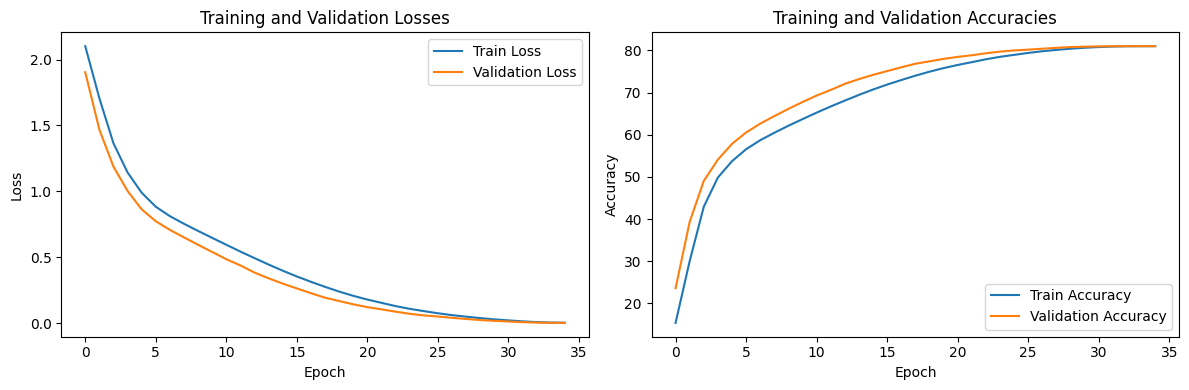

In [ ]:
# @title Plotting

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### 🔹 **Predicted the  test dataset.**

In [ ]:
# @title Loaded the test data to make predictions

path3 = '/content/drive/MyDrive/test_unsolved_sudoku (3).npy'
test_data_without_zeros = np.load(path3)

# Define a function to preprocess puzzles for prediction
def preprocess_puzzle(puzzle):
    puzzle_str = ''.join(map(str, puzzle.flatten()))
    return torch.tensor([int(p) for p in puzzle_str], dtype=torch.float32).reshape(1, 1, 9, 9) / 9 - 0.5

# Define a function to predict the test set
def predict_test_set(model, test_data):
    model.eval()
    predictions = []

    for i, puzzle in enumerate(test_data):
        puzzle_tensor = preprocess_puzzle(puzzle).unsqueeze(0).to(device)  # Add an extra dimension
        with torch.no_grad():
            solution = model(puzzle_tensor).argmax(dim=1).view(9, 9) + 1
            predictions.append(solution.cpu().numpy())

    return predictions

# Make predictions on the test set
predicted_solutions = predict_test_set(model, test_data_without_zeros)

# Create DataFrame for predictions
indexes, labels = [], []

for i, puzzle_solution in enumerate(predicted_solutions):
    for row in range(9):
        for col in range(9):
            index = f"{i}_{row}{col}"
            indexes.append(index)
            labels.append(puzzle_solution[row, col])

df_test_predictions = pd.DataFrame({"id": indexes, "values": labels})
df_test_predictions.to_csv("Predictions.csv", index=False)


In [ ]:
# @title Saved CSV file.
df_test_predictions.to_csv("solved_Submission.csv", index=False)

In [ ]:
# @title Preview of Submission File
pd.read_csv('/content/solved_Submission.csv')

,id,values
0,0_00,7
1,0_01,6
2,0_02,8
3,0_03,9
4,0_04,6
...,...,...
809995,9999_84,3
809996,9999_85,9
809997,9999_86,2
809998,9999_87,5
